# Using fNIRS Channel Variance as a Proxy for Measurement Noise

To improve statistics, channel pruning might not always be the way. 
An alternative is to use channel weights in the calculation of averages (e.g. across subjects) or image reconstruction. 
One way of weighting channels is by their estimated measurement noise. 
Variance can be a proxy of measurement noise, e.g. when calculated across trials of the same condition (within subject) or across time on the residual after GLM fit.
This notebook is WIP to provide help to explore this approach with a helper function (quality.measurement_variance) for this purpose.

In [68]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

import cedalion
import cedalion.datasets as datasets
import cedalion.nirs
import cedalion.sigproc.quality as quality
import cedalion.sigproc.motion_correct as motion_correct
from cedalion import units
import cedalion.xrutils as xrutils

%matplotlib widget

In [69]:
# some plotting helper functions for this notebook

def plot_heatmap(da, cov_wavelength=None, figsize=(12, 4), cmap=None):
    """ Plot either:
      1. A “variance” DataArray with dims ("channel", "wavelength"), as a channel×wavelength heatmap;
      2. A “covariance” DataArray with dims ("wavelength", "channel1", "channel2"), 
         by selecting exactly one wavelength (cov_wavelength) and plotting the channel1×channel2 matrix.

    Parameters
    ----------
    da : xarray.DataArray
        - If dims == ("channel", "wavelength"): plot variance (channels on x, wavelengths on y).
        - If dims == ("wavelength", "channel1", "channel2"): plot covariance at one wavelength.
    cov_wavelength : scalar, optional
        Required only when da.dims == ("wavelength", "channel1", "channel2"). Must be one of da.wavelength values.
    figsize : tuple of float, optional
        Figure size in inches. Defaults to (12, 4).
    cmap : str or matplotlib.Colormap, optional
        Which colormap to use. If None, uses the default.

    Returns
    -------
    fig, ax : matplotlib.Figure, matplotlib.Axes
        Figure and Axes objects, for any further customization.
    """

    dims = da.dims

    # 1) VARIANCE CASE: dims = ("channel", "wavelength")
    if set(dims) == {"channel", "wavelength"}:
        # Convert to pandas DataFrame so that rows = channels, cols = wavelengths
        df = da.to_pandas()

        # We want channels on the x-axis, wavelengths on the y-axis.
        #   df.values has shape (n_channels, n_wavelengths), so transpose → (n_wavelengths, n_channels)
        arr = df.values.T

        x_labels = df.index.tolist()         # channel names
        y_labels = [str(int(wl)) for wl in df.columns]  # wavelength values as strings

        x_dim_name = "channel"
        y_dim_name = "wavelength"
        cbar_label = "Variance"

    # 2) COVARIANCE CASE: dims = ("wavelength", "channel1", "channel2")
    elif set(dims) == {"wavelength", "channel1", "channel2"}:
        if cov_wavelength is None:
            raise ValueError(
                "When da.dims == ('wavelength','channel1','channel2'), you must supply cov_wavelength."
            )
        # Extract the 2D slice at that wavelength
        da2d = da.sel(wavelength=cov_wavelength)
        # Make sure dims are in order (channel1, channel2)
        da2d = da2d.transpose("channel1", "channel2")

        arr = da2d.values  # shape = (n_channel1, n_channel2)

        x_labels = da2d.coords["channel2"].values.tolist()
        y_labels = da2d.coords["channel1"].values.tolist()

        x_dim_name = "channel2"
        y_dim_name = "channel1"
        cbar_label = f"Covariance (λ={cov_wavelength})"

    else:
        raise ValueError(f"Unsupported DataArray dimensions: {dims}")

    # 3) Plot the 2D array with imshow
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(arr, aspect="auto", cmap=cmap)

    # 4) Set x-axis ticks/labels
    ax.set_xticks(range(len(x_labels)))
    ax.set_xticklabels(x_labels, rotation=90, fontsize=8)

    # 5) Set y-axis ticks/labels
    ax.set_yticks(range(len(y_labels)))
    ax.set_yticklabels(y_labels, fontsize=8)

    # 6) Label axes from the dimension names
    ax.set_xlabel(x_dim_name)
    ax.set_ylabel(y_dim_name)

    # 7) Add a colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label(cbar_label)

    plt.tight_layout()
    return fig, ax

## Plain Channel Variance
Note: channel variance can only be a proxy for measurement noise if calculated OD or CONC. Do not calculate on raw intensity.

Text(0, 0.5, 'Signal intensity / a.u.')

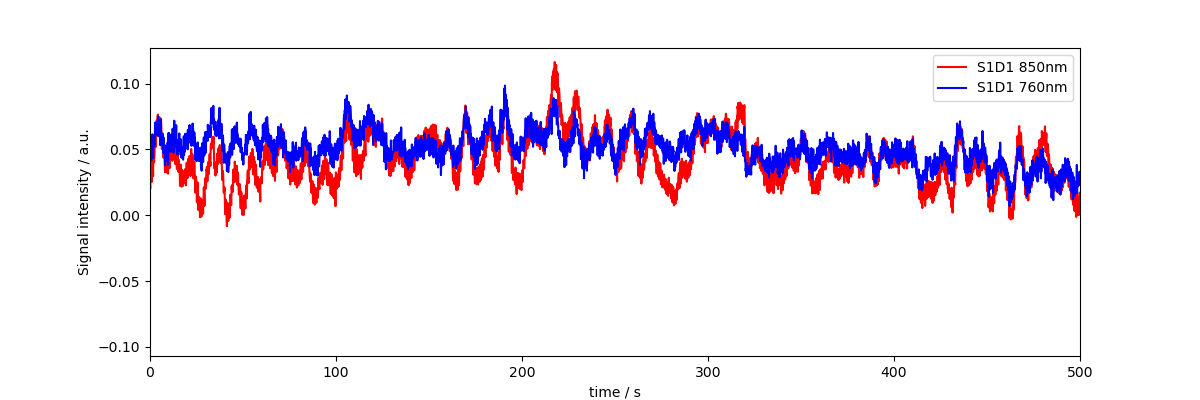

In [70]:
# get example finger tapping dataset
rec = datasets.get_fingertapping()
rec["od"] = cedalion.nirs.int2od(rec["amp"])


# Plot some data for visual validation
f,ax = plt.subplots(1,1, figsize=(12,4))
ax.plot( rec["od"].time, rec["od"].sel(channel="S1D1", wavelength="850"), "r-", label="S1D1 850nm")
ax.plot( rec["od"].time, rec["od"].sel(channel="S1D1", wavelength="760"), "b-", label="S1D1 760nm")
plt.legend()
ax.set_xlim(0, 500)
ax.set_xlabel("time / s")
ax.set_ylabel("Signal intensity / a.u.")

Calculate variance of all channels and display results

Magnitude,[[0.0008430816493820208 0.0009295065136174262] [0.00015688855588203332 0.00027444524616545483] [0.0017037950339317022 0.0009472470520227991] [0.0008904716853709997 0.0008872444095645721] [0.001529435631830583 0.0010295684794794336] [0.0027015366500955425 0.001719745753006718] [0.00206831099658647 0.0012277257176647309] [0.00018502094576474325 0.0001335334994146081] [0.0007023219329488201 0.0006433126934103153] [0.0006729449585267339 0.0007947006883202567] [0.0001262699432173282 0.0002114098402237839] [0.003180895552944404 0.0025489905010299546] [0.0039789720503357415 0.0031518609824904144] [6.411825718823878e-05 7.157702892294174e-05] [0.003538247877486314 0.0025076371382043716] [0.0002648489721931652 0.0003536278983179516] [0.004494369127528376 0.0038714227879609454] [0.0005784836389995566 0.0003922800526809329] [0.0037933153014002457 0.0028094658339701843] [0.002293649520104553 0.0013919624156644584] [0.005079136350416388 0.004124069102695085] [0.0001500760377988118 0.00013107681810134184] [0.0030859664970221048 0.003284031382606737] [0.0032741950962028483 0.0031225786505689403] [0.0004024926778591781 0.0003090724661795766] [0.0024456417101189217 0.0016790020379558106] [0.004407718284440757 0.0040704274904751715] [0.00042257809708487834 0.00023230120701514778]]
Units,dimensionless


c:\Users\avonl\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


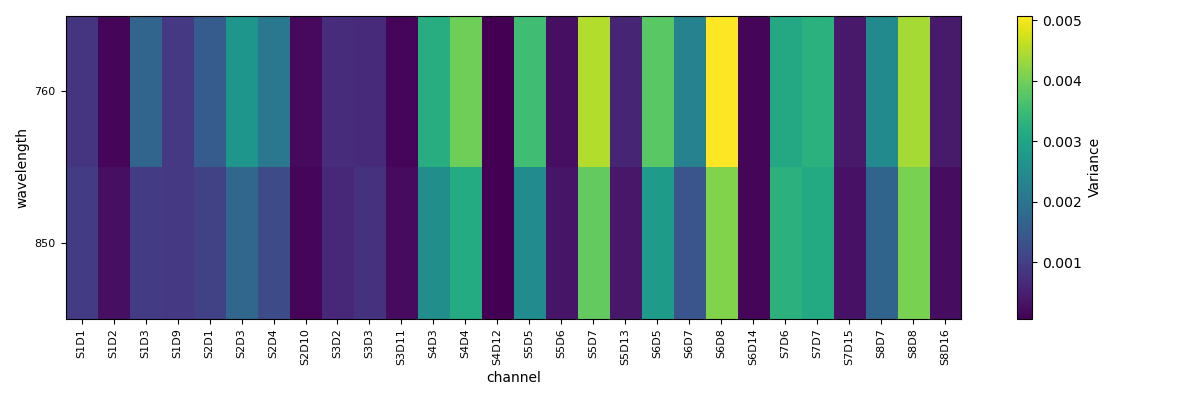

In [71]:
# calculate variance of optical density (OD) measurements for all channels and wavelengths
od_var = quality.measurement_variance(rec["od"])
display(od_var)

fig, ax = plot_heatmap(od_var)
plt.show()

From the plot above we can identify S6D8 (760nm) as a channel with high variance and and S1D2 (760nm) as a channel with low variance. S7D6 is somewhere inbetween.
Lets investigate how the corresponding time series looks like.

Text(0, 0.5, 'Signal intensity / a.u.')

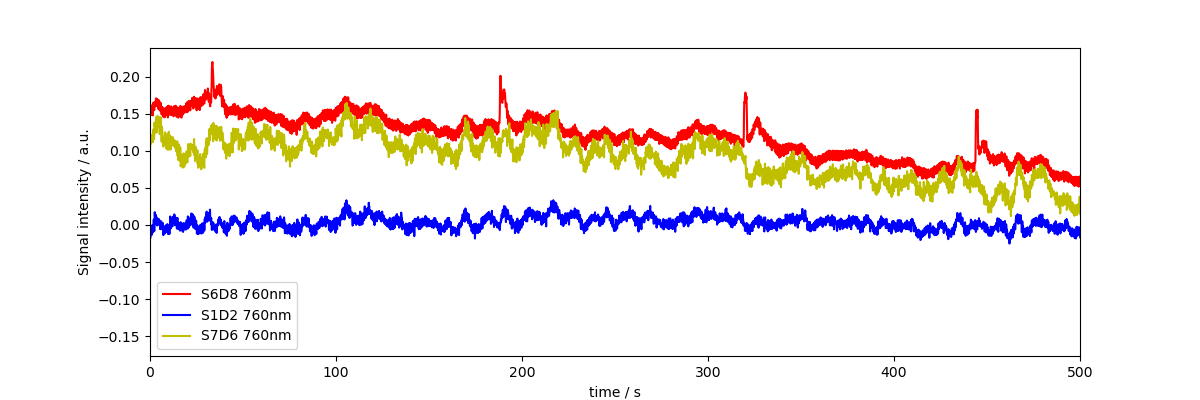

In [72]:
# Plot some data for visual validation
f,ax = plt.subplots(1,1, figsize=(12,4))
ax.plot( rec["od"].time, rec["od"].sel(channel="S6D8", wavelength="760"), "r-", label="S6D8 760nm")
ax.plot( rec["od"].time, rec["od"].sel(channel="S1D2", wavelength="760"), "b-", label="S1D2 760nm")
ax.plot( rec["od"].time, rec["od"].sel(channel="S7D6", wavelength="760"), "y-", label="S7D6 760nm")
plt.legend()
ax.set_xlim(0, 500)
ax.set_xlabel("time / s")
ax.set_ylabel("Signal intensity / a.u.")

We can see that the Channel with high variance has motion artifacts. These can be removed with [motion correction methods](https://doc.ibs.tu-berlin.de/cedalion/doc/dev/examples/signal_quality/22_motion_artefacts_and_correction.html) and we can recalculate the variance to see if this helped. If we don't, and use the channel variance as is for weighting in further processing, the channel with motion artifacts will be downweighted, as it has higher variance.

c:\Users\avonl\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


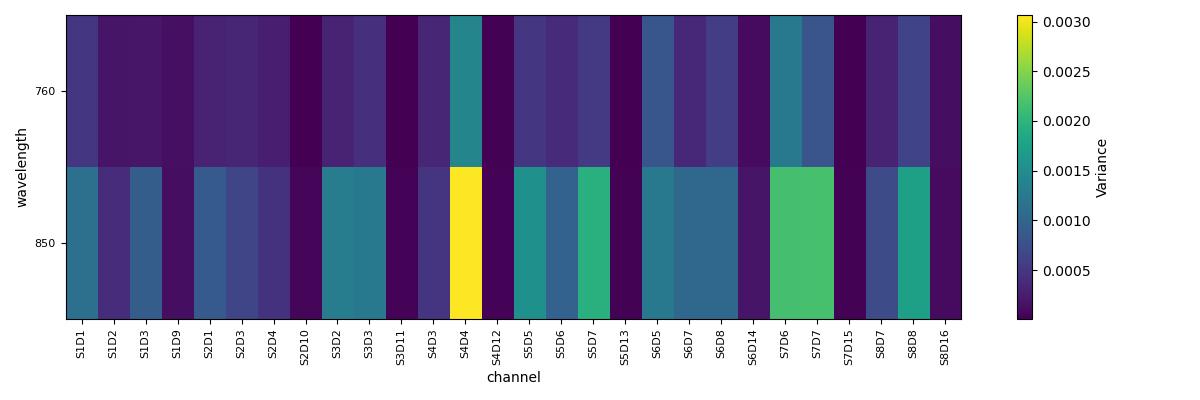

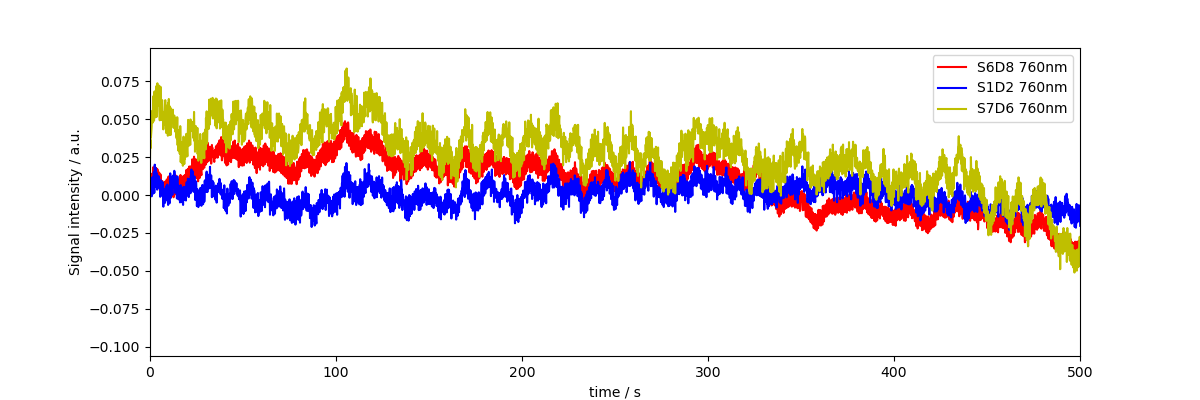

In [73]:
# motion correction using the wavelet and tddr methods  
rec["od_corrected"] = motion_correct.tddr(rec["od"])
rec["od_corrected"] = motion_correct.motion_correct_wavelet(rec["od_corrected"])


# Plot corrected data for visual validation
f,ax = plt.subplots(1,1, figsize=(12,4))
ax.plot( rec["od_corrected"].time, rec["od_corrected"].sel(channel="S6D8", wavelength="760"), "r-", label="S6D8 760nm")
ax.plot( rec["od_corrected"].time, rec["od_corrected"].sel(channel="S1D2", wavelength="760"), "b-", label="S1D2 760nm")
ax.plot( rec["od_corrected"].time, rec["od_corrected"].sel(channel="S7D6", wavelength="760"), "y-", label="S7D6 760nm")
plt.legend()
ax.set_xlim(0, 500)
ax.set_xlabel("time / s")
ax.set_ylabel("Signal intensity / a.u.")

# calculate variance on the corrected signal
od_var2 = quality.measurement_variance(rec["od_corrected"])


## Display results as a heatmap
fig, ax = plot_heatmap(od_var2)
plt.show()

We can see that motion correction took care of some variance (and therefore fixed some channels like S6D8), but not all of it, S4D4 remains partially noisy.

## Channel variance under consideration of flagged bad channels
There are cases in which we don't trust channel variance as a proxy for measurement noise. Examples are saturated channels.
We could  also want to penalize channels with motion artifacts particulalry strongly and for instance kick out S4D4, which did only partially profit from artifact rejection.
For this we can provide a list of "bad" channels and a custom weight.

Text(0, 0.5, 'Signal intensity / a.u.')

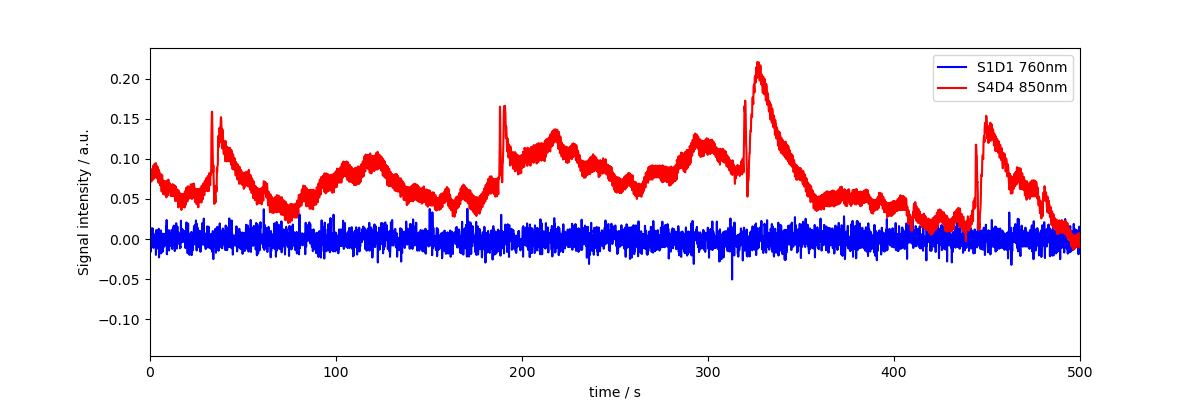

In [74]:
# lets assume we do not want to do motion correction and channel S1D1 is saturated. 
# We give S1D1 it a constant value of 1V with only the measurement noise of the system of 10mV
rec["amp"].loc[{"channel": "S1D1"}] = (1 + np.random.normal(0, 10e-3, rec["amp"].sel(channel="S1D1").shape))*units.V

# now convert the signal to optical density
rec["od"] = cedalion.nirs.int2od(rec["amp"])


# Plot some data for visual validation
f,ax = plt.subplots(1,1, figsize=(12,4))
ax.plot( rec["od"].time, rec["od"].sel(channel="S1D1", wavelength="760"), "b-", label="S1D1 760nm")
ax.plot( rec["od"].time, rec["od"].sel(channel="S4D4", wavelength="850"), "r-", label="S4D4 850nm")
plt.legend()
ax.set_xlim(0, 500)
ax.set_xlabel("time / s")
ax.set_ylabel("Signal intensity / a.u.")

Looking at the resulting variance of the saturated channel S1D2 and comparing it with the noisy (motion artifact) channel S4D4...

In [75]:
# calculate variance of optical density (OD) measurements for all channels and chromophores
od_var = quality.measurement_variance(rec["od"])

# print channel S1D1 760nm and channel S6D8 760nm variance 
print("S1D1 760nm variance:", od_var.sel(channel="S1D1", wavelength="760").values)
print("S4D4 760nm variance:", od_var.sel(channel="S4D4", wavelength="850").values)


c:\Users\avonl\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


S1D1 760nm variance: 9.842864935229795e-05
S4D4 760nm variance: 0.0031518609824904144


we can tell that the metric cannot account for saturation, and we should manually drop / downweight the saturated channel. 

c:\Users\avonl\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


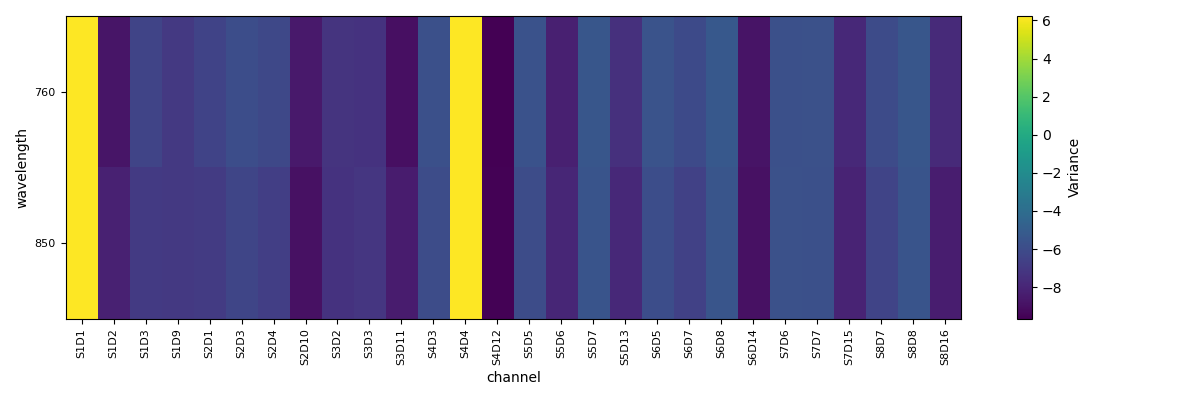

In [76]:
list_bad_channels = ["S1D1", "S4D4"]
bad_rel_var = 1e5 # we use a large factor that will be multiplied with the channel variance to effectively remove the channel from the analysis wherever it is weighted by its variance

od_var = quality.measurement_variance(rec["od"], list_bad_channels, bad_rel_var)

## Display results as a heatmap, this time on a logarithmic scale as the penalty factor is large
fig, ax = plot_heatmap(np.log(od_var))
plt.show()

## Using Variance as Proxy for measurement Noise to Downweight Channels
Lets apply this now, for instance to normalize signals using the noise proxy (smaller variance will amplify a signal)

c:\Users\avonl\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Text(0, 0.5, 'Signal intensity / a.u.')

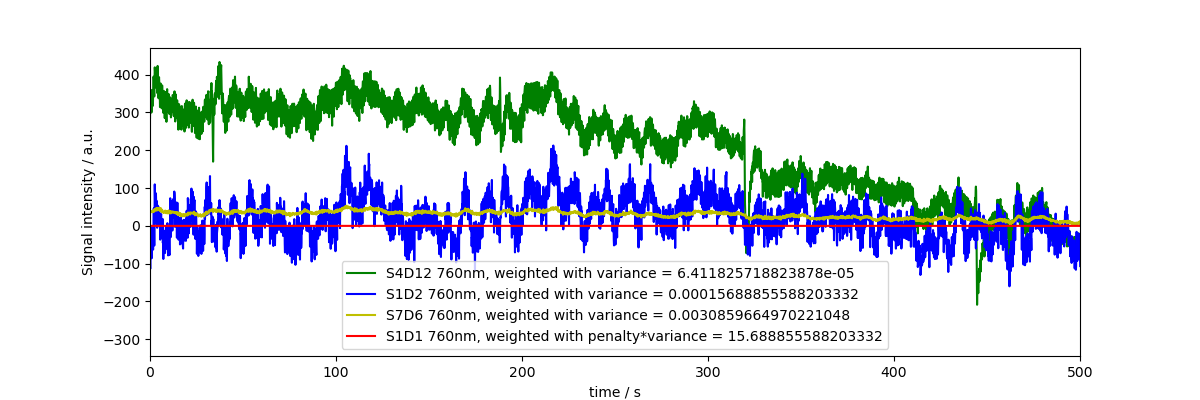

In [77]:
# normalize signals by their variance
rec["normalized_od"] = rec["od"] / od_var

# Plot normalized data for visual validation
f,ax = plt.subplots(1,1, figsize=(12,4))

ax.plot( rec["normalized_od"].time, rec["normalized_od"].sel(channel="S4D12", wavelength="760"), "g-", label="S4D12 760nm, weighted with variance = " +str(od_var.sel(channel="S4D12", wavelength="760").values))
ax.plot( rec["normalized_od"].time, rec["normalized_od"].sel(channel="S1D2", wavelength="760"), "b-", label="S1D2 760nm, weighted with variance = " +str(od_var.sel(channel="S1D2", wavelength="760").values))
ax.plot( rec["normalized_od"].time, rec["normalized_od"].sel(channel="S7D6", wavelength="760"), "y-", label="S7D6 760nm, weighted with variance = " +str(od_var.sel(channel="S7D6", wavelength="760").values))
ax.plot( rec["normalized_od"].time, rec["normalized_od"].sel(channel="S1D1", wavelength="760"), "r-", label="S1D1 760nm, weighted with penalty*variance = "+str(bad_rel_var*od_var.sel(channel="S1D2", wavelength="760").values))
plt.legend()
ax.set_xlim(0, 500)
ax.set_xlabel("time / s")
ax.set_ylabel("Signal intensity / a.u.")

## Channel Covariance
Lastly, we might also be interested in channel covariance...

Magnitude,[[[0.05079136350416388 0.045474440449042655 0.045474440449042655 ... 0.045474440449042655 0.045474440449042655 0.045474440449042655] [0.045474440449042655 0.0001568953072614931 0.00022540292982821478 ... 0.00024175903168906676 0.000276216376238691 9.306001626439994e-05] [0.045474440449042655 0.00022540292982821478 0.0017038683532807819 ... 0.001977842871317385 0.002588564916184136 0.0008230365233766352] ... [0.045474440449042655 0.00024175903168906676 0.001977842871317385 ... 0.002445746953328757 0.0031510372747779038 0.0009967204767186444] [0.045474440449042655 0.000276216376238691 0.002588564916184136 ... 0.0031510372747779038 0.004407907961619707 0.0012988271299786008] [0.045474440449042655 9.306001626439994e-05 0.0008230365233766352 ... 0.0009967204767186444 0.0012988271299786008 0.0004225962818726006]] [[0.05079136350416388 0.03755455029254035 0.03755455029254035 ... 0.03755455029254035 0.03755455029254035 0.03755455029254035] [0.03755455029254035 0.0002744570563576471 0.00013564169083770942 ... 7.187701242129307e-05 -4.5632839450479146e-05 -5.2804210667320654e-06] [0.03755455029254035 0.00013564169083770942 0.0009472878148703787 ... 0.0011715362163940383 0.0016619539405530255 0.000417517769247884] ... [0.03755455029254035 7.187701242129307e-05 0.0011715362163940383 ... 0.0016790742903888055 0.0023609257127333604 0.0005788062577575429] [0.03755455029254035 -4.5632839450479146e-05 0.0016619539405530255 ... 0.0023609257127333604 0.004070602653031785 0.0008576991318586285] [0.03755455029254035 -5.2804210667320654e-06 0.000417517769247884 ... 0.0005788062577575429 0.0008576991318586285 0.00023231120362445247]]]
Units,dimensionless


c:\Users\avonl\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


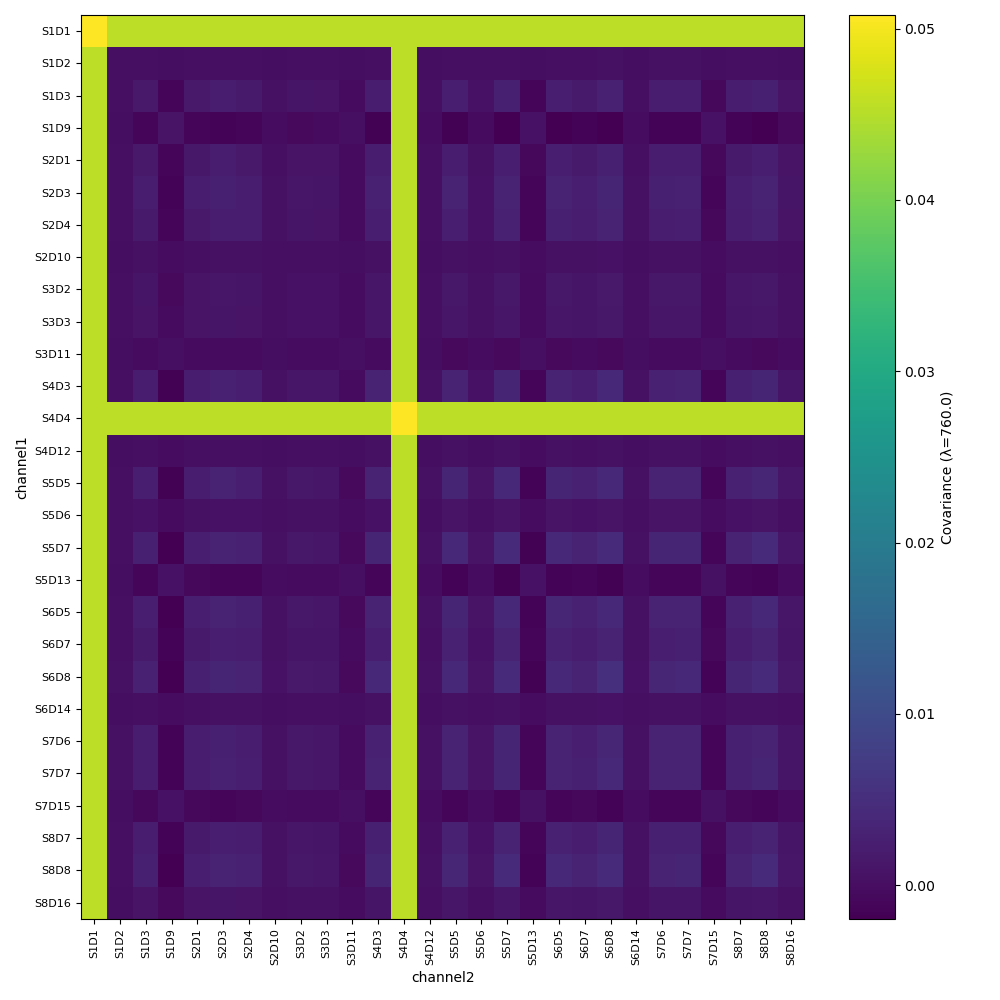

In [78]:
# use the same function to calculate the covariance of the optical density measurements
list_bad_channels = ["S1D1", "S4D4"]
bad_rel_var = 10  # much smaller factor than the default just to highlight the effect

od_covar = quality.measurement_variance(rec["od"], list_bad_channels, bad_rel_var, calc_covariance=True)
display(od_covar)


# use log(Var) again because we penalized the bad channels with a large factor
fig, ax = plot_heatmap(od_covar, cov_wavelength=760.0, figsize=(10, 10))
plt.show()

## (Weighted) Global Physiology Removal 

In [ ]:
import numpy as np
import xarray as xr
from sklearn.decomposition import PCA

def global_physio_subtract(
    ts: xr.DataArray,
    ts_weights: xr.DataArray = None,
    k: float = 0,
    channel_dim: str = "channel",
    spectral_dim: str = None
) -> tuple:
    """
    Remove global physiological components from a time series by either weighted‐mean subtraction
    (if k=0) or PCA (if k>0). Returns both the corrected time series and the global component
    that was removed (the weighted‐mean regressor if k=0, or the first principal component time series if k>0).

    Parameters
    ----------
    ts : xr.DataArray
        Input DataArray. Must have a "time" dimension, one dimension for channels
        (default name "channel") and one for spectral info ("wavelength" or "chromophore").
    ts_weights : xr.DataArray, optional
        A DataArray of per‐(channel_dim × spectral_dim) variances to use as weights. If None,
        all weights = 1 (no weighting). Must have dims (channel_dim, spectral_dim).
    k : float, default=0
        • k = 0: perform weighted‐mean subtraction (per spectral slice).
        • k ≥ 1: remove the first int(k) principal components per spectral slice.
        • 0 < k < 1: remove the minimum number of PCs whose cumulative explained variance ≥ k.
    channel_dim : str, default "channel"
        Name of the “channel-like” dimension. If absent, no subtraction is done.
    spectral_dim : str, optional
        Name of the spectral dimension (e.g. "wavelength" or "chromophore"). If None, inferred
        as the dimension in ts.dims that is neither "time" nor channel_dim.

    Returns
    -------
    corrected : xr.DataArray
        The time series with global physiological components removed.
    global_component : xr.DataArray
        If k=0: the weighted‐mean regressor (dims: "time", spectral_dim).
        If k>0: the first principal component time series for each spectral slice
                  (dims: "time", spectral_dim).

    Raises
    ------
    ValueError
        - If "time" not in ts.dims.
        - If channel_dim and spectral_dim cannot be identified.
        - If ts_weights is provided but does not have dims (channel_dim, spectral_dim).
        - If k < 0 or invalid for PCA.
    """

    # 1) Ensure “time” exists
    if "time" not in ts.dims:
        raise ValueError("Input ts must have a 'time' dimension.")

    # 2) Infer spectral_dim if not provided
    if spectral_dim is None:
        other_dims = [d for d in ts.dims if d not in ("time", channel_dim)]
        if len(other_dims) != 1:
            raise ValueError(
                f"Could not infer spectral_dim from ts.dims {ts.dims}. "
                "Please supply spectral_dim explicitly."
            )
        spectral_dim = other_dims[0]

    # 3) If channel_dim is absent, simply return ts and a zeroed global_component
    if channel_dim not in ts.dims:
        corrected = ts.copy()
        zero_global = xr.zeros_like(ts.isel({channel_dim: 0})).drop_vars(channel_dim)
        return corrected, zero_global

    # 4) Validate that spectral_dim is indeed in ts.dims
    if spectral_dim not in ts.dims:
        raise ValueError(f"Spectral dimension '{spectral_dim}' not in ts.dims {ts.dims}.")

    # 5) Preserve pint‐units if present, then strip them for numeric ops
    if hasattr(ts, "pint"):
        orig_units = ts.pint.units
        ts_vals = ts.pint.dequantify().copy()
    else:
        orig_units = 1
        ts_vals = ts.copy()

    # 6) Build or validate ts_weights (variances)
    if ts_weights is None:
        var_vals = xr.ones_like(ts_vals.isel(time=0).drop_vars("time"))
    else:
        if not isinstance(ts_weights, xr.DataArray):
            raise ValueError("ts_weights must be an xarray.DataArray with dims (channel_dim, spectral_dim).")
        if set(ts_weights.dims) != {channel_dim, spectral_dim}:
            raise ValueError(
                f"ts_weights must have dims ({channel_dim},{spectral_dim}), but got {ts_weights.dims}."
            )
        if hasattr(ts_weights, "pint"):
            var_vals = ts_weights.pint.dequantify().copy()
        else:
            var_vals = ts_weights.copy()

    # 7) Pull out coords and sizes
    time_coord = ts_vals.coords["time"]
    chan_coord = ts_vals.coords[channel_dim]
    spec_coord = ts_vals.coords[spectral_dim]

    n_time = ts_vals.sizes["time"]
    n_chan = ts_vals.sizes[channel_dim]

    # 8) Prepare an empty DataArray for the corrected output (plain‐float)
    corrected = xr.zeros_like(ts_vals)

    # 9) Prepare a DataArray for the global component
    global_comp = xr.DataArray(
        np.zeros((n_time, ts_vals.sizes[spectral_dim])),
        dims=("time", spectral_dim),
        coords={"time": time_coord, spectral_dim: spec_coord},
    )

    # ──────────────────────────────────────────────────────────────────────────────
    # CASE A: k == 0 → Weighted mean subtraction across channel_dim
    # ──────────────────────────────────────────────────────────────────────────────
    if k == 0:
        # Compute per‐(channel,spectral) weight = 1/var
        w = 1.0 / var_vals  # dims: (channel_dim, spectral_dim)

        # For each spectral slice s, build the global regressor:
        numerator = (ts_vals * w).sum(dim=channel_dim)   # dims: (time, spectral)
        denominator = w.sum(dim=channel_dim)             # dims: (spectral)
        gms = numerator / denominator                     # dims: (time, spectral)

        # Save gms as the global component
        global_comp[:] = gms

        # Next, find the best-fit scalar for each (channel, spectral)
        num = (ts_vals * gms).sum(dim="time")             # dims: (channel, spectral)
        denom = (gms * gms).sum(dim="time")               # dims: (spectral)
        scl = num / denom                                 # dims: (channel, spectral)

        # Build and subtract full component
        full_component = scl * gms  # dims: (time, channel, spectral)
        corrected = ts_vals - full_component

    # ──────────────────────────────────────────────────────────────────────────────
    # CASE B: k > 0 → PCA‐based removal (PCA always on channel_dim)
    # ──────────────────────────────────────────────────────────────────────────────
    else:
        # Determine if k is a fraction (0<k<1) or integer (k>=1)
        if 0 < k < 1:
            remove_frac = True
        else:
            remove_frac = False
            n_remove_int = int(np.floor(k))
            if n_remove_int < 1:
                raise ValueError(f"Invalid k={k}. For PCA, int(k) must be ≥ 1.")

        # Loop over each spectral slice independently
        for s in spec_coord.values:
            # Explicitly transpose so that data_matrix is (time, channel)
            ts_slice = ts_vals.sel({spectral_dim: s}).transpose("time", channel_dim)
            data_matrix = ts_slice.values  # shape = (n_time, n_chan)

            # Pull out per‐channel variance for this slice
            channel_vars = var_vals.sel({spectral_dim: s}).values  # shape = (n_chan,)

            # Pre‐whiten if weights provided
            if ts_weights is not None:
                sqrt_vars = np.sqrt(channel_vars)
                sqrt_vars = np.where(sqrt_vars == 0, 1.0, sqrt_vars)
                data_w = data_matrix / sqrt_vars[np.newaxis, :]  # shape = (n_time, n_chan)
            else:
                data_w = data_matrix.copy()

            # Decide how many PCs to remove
            if remove_frac:
                pca_full = PCA()
                pca_full.fit(data_w)
                cumvar = np.cumsum(pca_full.explained_variance_ratio_)
                n_remove = np.searchsorted(cumvar, k) + 1
                n_remove = min(n_remove, n_chan - 1)
            else:
                n_remove = n_remove_int

            # No PCs to remove → global_comp = 0
            if n_remove < 1:
                corrected_slice = data_matrix
                global_comp.loc[:, s] = 0.0
            else:
                # Fit PCA(n_remove) on data_w (rows=time, cols=channel)
                pca = PCA(n_components=n_remove)
                scores = pca.fit_transform(data_w)             # (n_time, n_remove)
                reconstructed_w = pca.inverse_transform(scores)  # (n_time, n_chan)

                # First PC time series (pre-whitened)
                if ts_weights is not None:
                    loading_w = pca.components_[0, :]                   # (n_chan,) in whitened space
                    # Convert to original‐space loading: L_orig = loading_w / sqrt_vars
                    loading_orig = loading_w / sqrt_vars                 # (n_chan,)
                    # Project raw data_matrix onto loading_orig to get PC time series in original units
                    global_ts = data_matrix @ loading_orig               # (n_time,)
                else:
                    loading = pca.components_[0, :]                      # (n_chan,) in unweighted space
                    global_ts = data_w @ loading                      # (n_time,)

                # Assign first-PC time series to global_comp
                global_comp.loc[:, s] = global_ts

                # Reconstruct in original units and subtract
                if ts_weights is not None:
                    reconstructed = reconstructed_w * sqrt_vars[np.newaxis, :]
                else:
                    reconstructed = reconstructed_w

                corrected_slice = data_matrix - reconstructed

            # Write corrected_slice back into `corrected`
            #corrected.loc[:, :, s] = corrected_slice
            corrected.loc[{spectral_dim: s}] = xr.DataArray(
                corrected_slice,
                dims=("time", channel_dim),
                coords={"time": time_coord, channel_dim: chan_coord},
            )

    # 10) Reattach pint‐units if we stripped them off
    if orig_units is not None and orig_units != 1:
        corrected = corrected * orig_units
        global_comp = global_comp * orig_units

    # 11) Preserve any original attributes
    corrected.attrs = ts.attrs.copy()
    global_comp.attrs = {"description": "Global physiological component removed"}

    return corrected, global_comp

In [97]:
from cedalion.sigproc import frequency

# Refresh Data
rec["od"] = cedalion.nirs.int2od(rec["amp"])

# highpass filter data to remove slow drifts
rec["od"] = frequency.freq_filter(rec["od"], fmin=0.01*units.Hz, fmax=2*units.Hz, butter_order=4)

# initialize empty dictionary
diff = {}

### (Fitted) Global Mean Subtraction

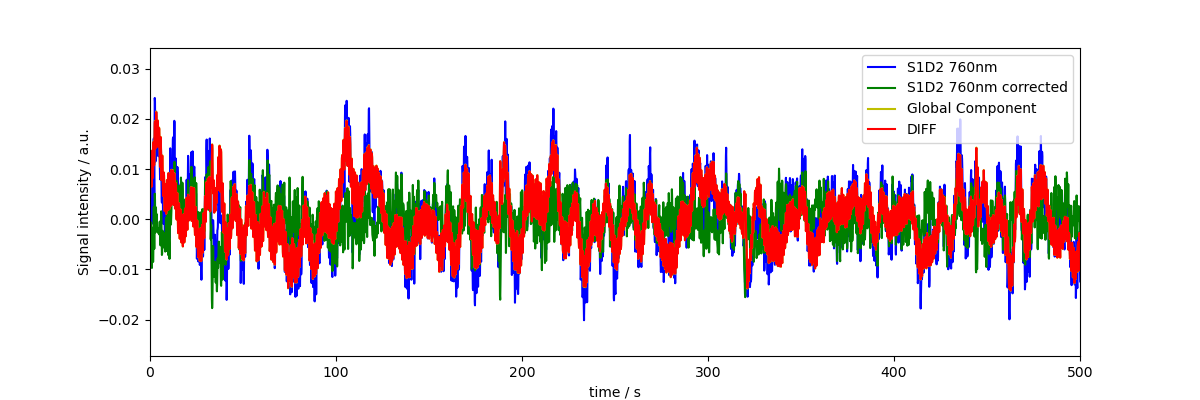

In [ ]:
dname = "od_corr_gm"

rec[dname], global_comp = global_physio_subtract(rec["od"], ts_weights=None, k=0)
diff[dname] = rec[dname] - rec["od"]


channel = "S1D2"  # channel to be displayed
wavelength = "760"  # wavelength to be displayed

# Plot some data for visual validation
f,ax = plt.subplots(1,1, figsize=(12,4))
ax.plot( rec["od"].time, rec["od"].sel(channel=channel, wavelength=wavelength), "b-", label="S1D2 760nm")
ax.plot( rec[dname].time, rec[dname].sel(channel=channel, wavelength=wavelength), "g-", label="S1D2 760nm corrected")
ax.plot( global_comp.time, global_comp.sel(wavelength=wavelength), "y-", label="Global Component")
ax.plot( rec["od"].time, diff[dname].sel(channel=channel, wavelength=wavelength), "r-", label="DIFF")
plt.legend()
ax.set_xlim(0, 500)
ax.set_xlabel("time / s")
ax.set_ylabel("Signal intensity / a.u.")
display()

### Weighted Global Mean Subtraction

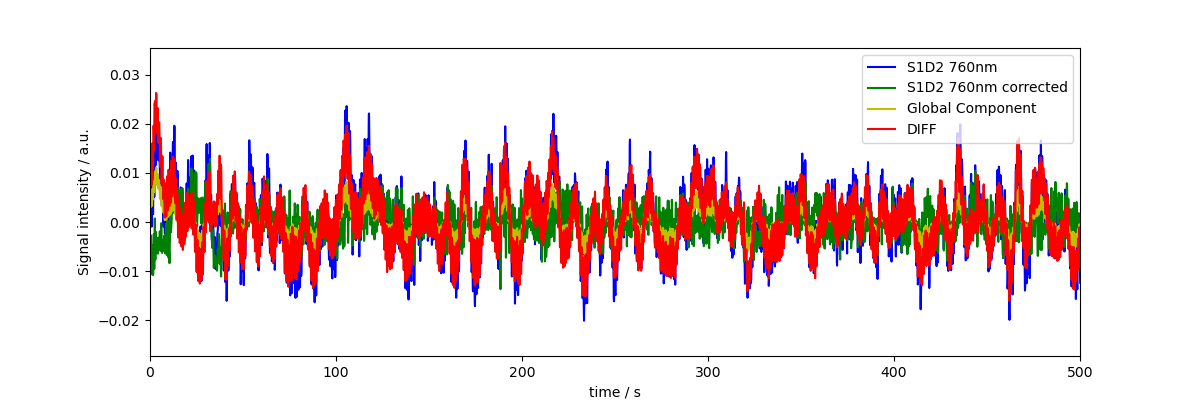

In [ ]:
od_var = quality.measurement_variance(rec["od"], calc_covariance=False)

dname = "od_corr_gm"
rec[dname], global_comp = global_physio_subtract(rec["od"], ts_weights=od_var, k=0)
diff[dname] = rec[dname] - rec["od"]


channel = "S1D2"  # channel to be displayed
wavelength = "760"  # wavelength to be displayed

# Plot some data for visual validation
f,ax = plt.subplots(1,1, figsize=(12,4))
ax.plot( rec["od"].time, rec["od"].sel(channel=channel, wavelength=wavelength), "b-", label="S1D2 760nm")
ax.plot( rec[dname].time, rec[dname].sel(channel=channel, wavelength=wavelength), "g-", label="S1D2 760nm corrected")
ax.plot( global_comp.time, global_comp.sel(wavelength=wavelength), "y-", label="Global Component")
ax.plot( rec["od"].time, diff[dname].sel(channel=channel, wavelength=wavelength), "r-", label="DIFF")
plt.legend()
ax.set_xlim(0, 500)
ax.set_xlabel("time / s")
ax.set_ylabel("Signal intensity / a.u.")
display()

### Remove exactly the first Principal Component (unweighted)

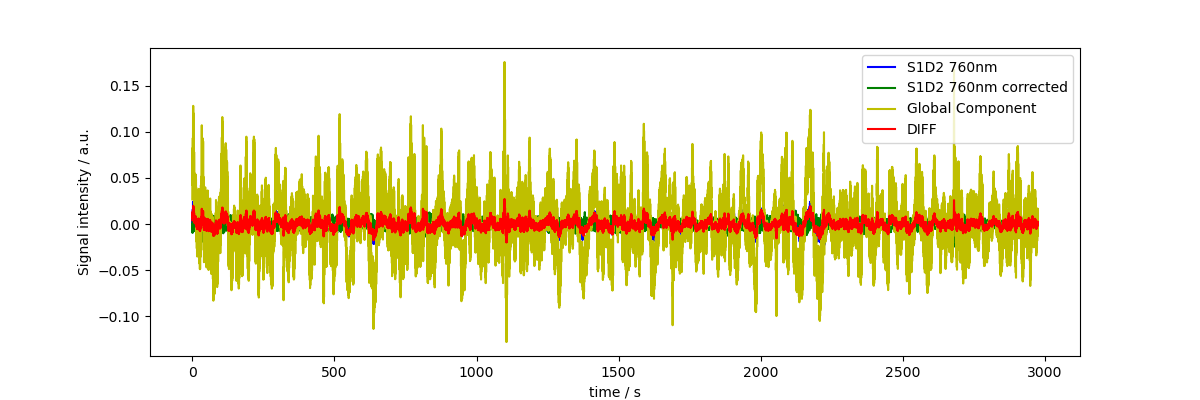

In [ ]:
dname = "od_corr_1pc"
rec[dname], global_comp = global_physio_subtract(rec["od"], ts_weights=None, k=1)
diff[dname] = rec[dname] - rec["od"]


channel = "S1D2"  # channel to be displayed
wavelength = "760"  # wavelength to be displayed

# Plot some data for visual validation
f,ax = plt.subplots(1,1, figsize=(12,4))
ax.plot( rec["od"].time, rec["od"].sel(channel=channel, wavelength=wavelength), "b-", label="S1D2 760nm")
ax.plot( rec[dname].time, rec[dname].sel(channel=channel, wavelength=wavelength), "g-", label="S1D2 760nm corrected")
ax.plot( global_comp.time, global_comp.sel(wavelength=wavelength), "y-", label="Global Component")
ax.plot( rec["od"].time, diff[dname].sel(channel=channel, wavelength=wavelength), "r-", label="DIFF")
plt.legend()
ax.set_xlim(0, 500)
ax.set_xlabel("time / s")
ax.set_ylabel("Signal intensity / a.u.")
display()

### Remove 1 PCA component but using measurement‐variance weights on the data

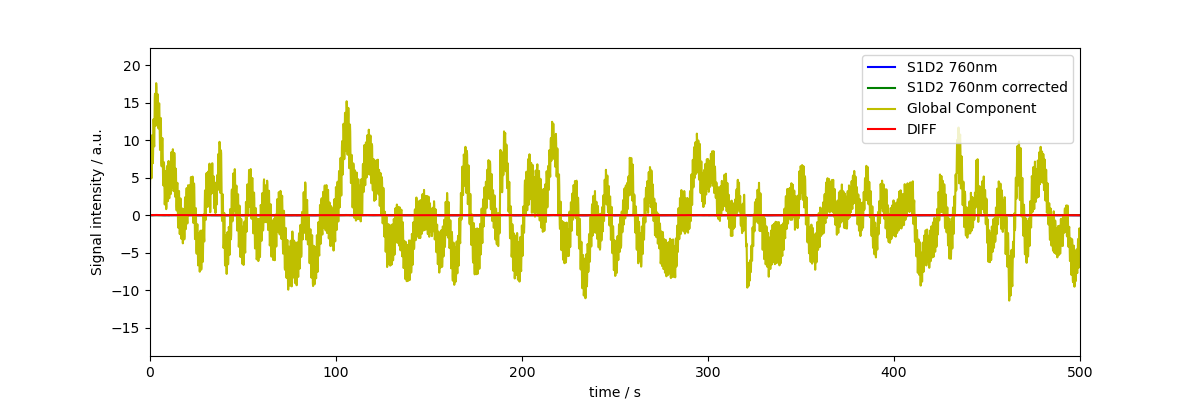

In [ ]:
od_var = quality.measurement_variance(rec["od"], calc_covariance=False)
dname = "od_corr_w1pc"

rec[dname], global_comp = global_physio_subtract(rec["od"], ts_weights=od_var, k=1)
diff[dname] = rec[dname] - rec["od"]


channel = "S1D2"  # channel to be displayed
wavelength = "760"  # wavelength to be displayed

# Plot some data for visual validation
f,ax = plt.subplots(1,1, figsize=(12,4))
ax.plot( rec["od"].time, rec["od"].sel(channel=channel, wavelength=wavelength), "b-", label="S1D2 760nm")
ax.plot( rec[dname].time, rec[dname].sel(channel=channel, wavelength=wavelength), "g-", label="S1D2 760nm corrected")
ax.plot( global_comp.time, global_comp.sel(wavelength=wavelength), "y-", label="Global Component")
ax.plot( rec["od"].time, diff[dname].sel(channel=channel, wavelength=wavelength), "r-", label="DIFF")
plt.legend()
ax.set_xlim(0, 500)
ax.set_xlabel("time / s")
ax.set_ylabel("Signal intensity / a.u.")
display()

### Remove 80% of global variance (weighted)

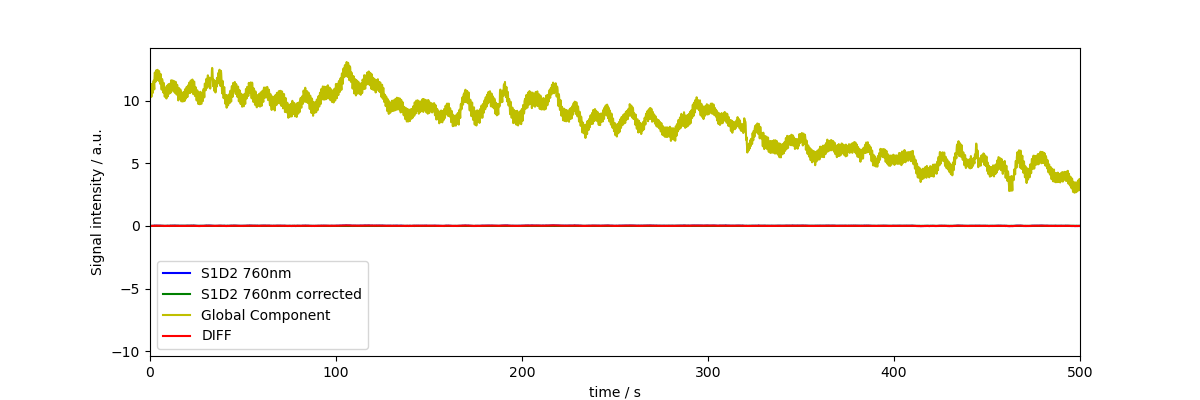

In [ ]:
dname = "od_corr_w0.8pc"
rec[dname], global_comp = global_physio_subtract(rec["od"], ts_weights=od_var, k=0.8)
diff[dname] = rec[dname] - rec["od"]


channel = "S1D2"  # channel to be displayed
wavelength = "760"  # wavelength to be displayed

# Plot some data for visual validation
f,ax = plt.subplots(1,1, figsize=(12,4))
ax.plot( rec["od"].time, rec["od"].sel(channel=channel, wavelength=wavelength), "b-", label="S1D2 760nm")
ax.plot( rec[dname].time, rec[dname].sel(channel=channel, wavelength=wavelength), "g-", label="S1D2 760nm corrected")
ax.plot( global_comp.time, global_comp.sel(wavelength=wavelength), "y-", label="Global Component")
ax.plot( rec["od"].time, diff[dname].sel(channel=channel, wavelength=wavelength), "r-", label="DIFF")
plt.legend()
ax.set_xlim(0, 500)
ax.set_xlabel("time / s")
ax.set_ylabel("Signal intensity / a.u.")
display()